In [18]:
# Importing libraries

# For the PyTorch neural network:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.nn.modules.loss import BCEWithLogitsLoss

# For plots
import matplotlib.pyplot as plt

# Numpy is a handy way to deal with matrices and tensors
import numpy as np

# Utilities for preparing the dataset
import os
from PIL import Image


import torch
torch.manual_seed(5) # this makes the training reproducible: every training have the same initialization

from torchviz import make_dot

from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph

import graphviz


In [19]:
import my_utilities as fun
import ClassicModelClass as classic_model

In [20]:
parasitized_images=fun.load_images("../Dataset/parasitized/")
uninfected_images=fun.load_images('../Dataset/uninfected/')
model_folder="ZZRAModelResults/"
model_name="ZZRA150Epochs"
nEp=4

../Dataset/parasitized/
../Dataset/uninfected/


In [21]:
#split data in 2 subsets: the first one is used for training and second one for validation
#also return 2 vectors (train_lb and val_lb) containing ones if the images is parasitized 0 else
#note that the last parameter is used to shuffle data
train_set,val_set,train_lb,val_lb=fun.create_2_subsets(parasitized_images,uninfected_images,42)


#convert data to Torch tensor type (annoying but necessary)
train_set_torch,val_set_torch,train_lb_torch,val_lb_torch=fun.data_to_torch(train_set,val_set,train_lb,val_lb)
#convert dato to dataLoader type
dataloader_train,dataloader_val=fun.create_dataloader_from_torchdata(train_set_torch, train_lb_torch,val_set_torch, val_lb_torch)



In [22]:
# defining the model
classic_model = classic_model.Net()
#print(model)
# defining the optimizer
optimizer = Adam(classic_model.parameters(), lr=0.0001)
# defining the loss function
loss_function = BCEWithLogitsLoss()

In [23]:
# defining the training function
def train(epoch, val_set, val_lb, train_set, train_lb):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader_train): #enumerate method adds counter to an iterable and returns it. The returned object is an enumerate object
        #model(x) invokes the call method wich calls the forward method
        #in y_batch there is the label
        y_batch_prediction = classic_model(x_batch)          
        y_batch = torch.reshape(y_batch, [y_batch.shape[0], 1])
        loss_train = loss_function(y_batch_prediction, y_batch)
        # train_losses.append(loss_train.detach().numpy())
        
        #clear gradients
        optimizer.zero_grad()
        
        #backpropagation, compute gradients
        loss_train.backward()
        
        #apply gradient
        optimizer.step()
   
    y_pred = classic_model(val_set)
    val_lb = torch.reshape(val_lb, [val_lb.shape[0], 1])
    loss_val = loss_function(y_pred, val_lb)
    val_losses.append(loss_val.detach().numpy())

    y_pred = classic_model(train_set)
    train_lb = torch.reshape(train_lb, [train_lb.shape[0], 1])
    loss_train = loss_function(y_pred, train_lb)
    train_losses.append(loss_train.detach().numpy())

In [24]:
# defining the number of epochs
n_epochs = nEp
# empty list to store training losses
train_losses = []
accuracy_train_losses=[]
# empty list to store validation losses
val_losses = []
# training the model
comodo=0
for epoch in range(n_epochs):
    comodo=comodo+1
    train(epoch, val_set_torch, val_lb_torch, train_set_torch, train_lb_torch)
    print(train_losses[epoch])
    scores_train = torch.sigmoid(classic_model(train_set_torch))[:,0]
    predictions_train = scores_train > 0.5
    accuracy_train = (predictions_train == train_lb_torch).sum()/ train_lb_torch.shape[0]
    print("accuracy on training set for epoch number "+str(comodo)+" ", accuracy_train.numpy())
    accuracy_train_losses.append(accuracy_train.numpy())

0.69600844
accuracy on training set for epoch number 1  0.505
0.69545335
accuracy on training set for epoch number 2  0.505
0.69484633
accuracy on training set for epoch number 3  0.505
0.6935205
accuracy on training set for epoch number 4  0.505



(process:22680): Pango-WARNING **: 14:51:11.327: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:25316): Pango-WARNING **: 14:51:11.502: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


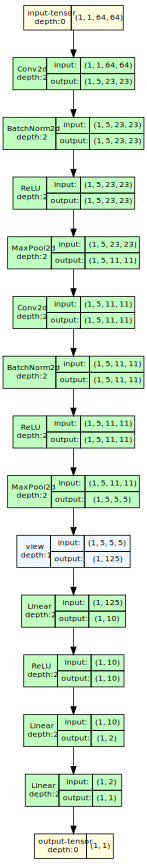

In [25]:
#create a png representing the convolutional neural network architecture
model_graph = draw_graph(classic_model, input_size=(1, 1, 64, 64), save_graph= True, filename = "cnn_architecture")
#show the architecture
model_graph.visual_graph

# graphviz.set_jupyter_format('png')

In [26]:
#QUANTUM PART
#------------------------------------------------------------------------------------------------------------------------

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from numpy import pi
import time

def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    #print(feature_map.parameters)
    #paramToTrain = ParameterVector('par', 3)
    #print(param1)
    
    qc = QuantumCircuit(2)
    qc.compose(ansatz, inplace=True)
    qc.compose(feature_map, inplace=True)
    
    print(ansatz)
    qc.draw('mpl')

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters ,
        input_gradients=True,
    )
    return qnn

In [27]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        # Defining layers that are specific of the CNN
        self.cnn_layers = Sequential(
             # Defining a 2D convolution layer
            Conv2d(1, 5, kernel_size=5, stride=3, padding=4),
            BatchNorm2d(5), # A normalization layer (not important to study)
            ReLU(inplace=True), # The activation funcion (Rectified Linear Unit)
            MaxPool2d(kernel_size=2, stride=2), # Pooling layer
            # Defining another 2D convolution layer
            Conv2d(5, 5, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        # Defining a normal layer of neurons (usually called Linear, Dense, or similar)
        self.linear_layers = Sequential(
            Linear(125, 10),
            ReLU(inplace=True),
            # Dropout(0.1),
            Linear(10, 2),
            #ReLU(inplace=True),
            # Dropout(0.1),
        )
        self.qnn = TorchConnector(qnn) 
        self.linear_layers2 = Sequential(
            Linear(1,1)
        )

    # Defining the forward pass    
    def forward(self, x):
        # First, applying all the convolutional stuff
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # not important
        # Second applying all the linear layers (only one for now)
        x = self.linear_layers(x)
        x = self.qnn(x)
        #x = self.linear_layers2(x)
        return x

In [28]:
# defining the model
qnn=create_qnn()

quantum_model = Net()
graph_hybrid = draw_graph(quantum_model, input_size=(1, 1, 64, 64), save_graph= True, filename = "cnn_architecture")
#show the architecture
graph_hybrid.visual_graph
print(quantum_model)
# defining the optimizer
optimizer = Adam(quantum_model.parameters(), lr=0.0001)
# defining the loss function
criterion = BCEWithLogitsLoss()


(process:652): Pango-WARNING **: 14:51:11.817: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘
Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(3, 3), padding=(4, 4))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=125, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
  (q

In [29]:
# defining the number of epochs
train_losses = []
accuracy_train_losses=[]
# empty list to store validation losses
val_losses = []
epochs = nEp
# empty list to store training losses
train_lossesq = []
# empty list to store validation losses
val_lossesq = []
accuracyTrainLossesq=[]
toc=0
tic=0
# training the model
for epoch in range(epochs):
    print("epoch")
    total_loss=[]
    tic=time.perf_counter()
    for id_batch, (data, label) in enumerate(dataloader_train):
        optimizer.zero_grad(set_to_none=True)
        output=quantum_model(data)
        label=torch.reshape(label,[label.shape[0], 1])
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    toc = time.perf_counter()
    print(f" time :  {toc - tic:0.4f} seconds")
    train_lossesq.append(sum(total_loss)/len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, train_lossesq[-1]))
    y_pred = quantum_model(val_set_torch)
    val_lb = torch.reshape(val_lb_torch, [val_lb_torch.shape[0], 1])
    loss_val = loss_function(y_pred, val_lb)
    val_lossesq.append(loss_val.detach().numpy())
    scores_train = torch.sigmoid(quantum_model(train_set_torch))[:,0]
    predictions_train = scores_train > 0.5
    accuracy_train = (predictions_train == train_lb_torch).sum()/ train_lb_torch.shape[0]
    print("accuracy on training set for epoch number "+str(epoch)+" ", accuracy_train.numpy())
    accuracyTrainLossesq.append(accuracy_train.numpy())

epoch
 time :  66.3014 seconds
Training [25%]	Loss: 0.7241
accuracy on training set for epoch number 0  0.50375
epoch
 time :  64.7572 seconds
Training [50%]	Loss: 0.7116
accuracy on training set for epoch number 1  0.4975
epoch
 time :  67.6881 seconds
Training [75%]	Loss: 0.7032
accuracy on training set for epoch number 2  0.51
epoch
 time :  63.9569 seconds
Training [100%]	Loss: 0.6955
accuracy on training set for epoch number 3  0.51875


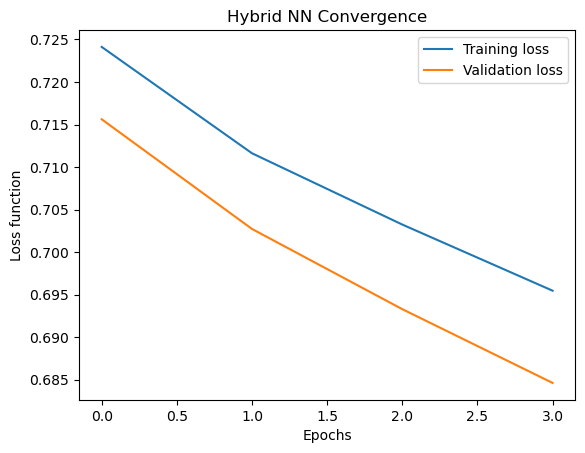

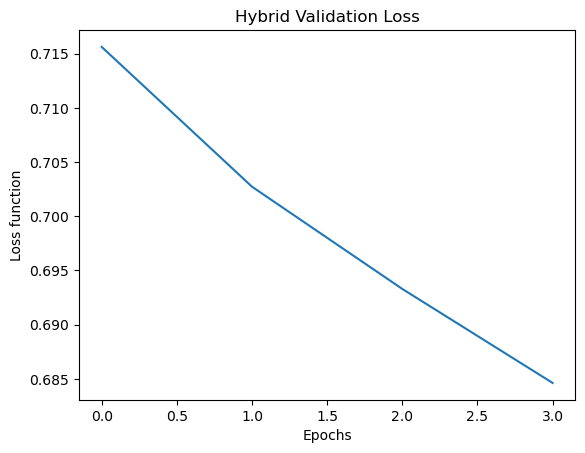

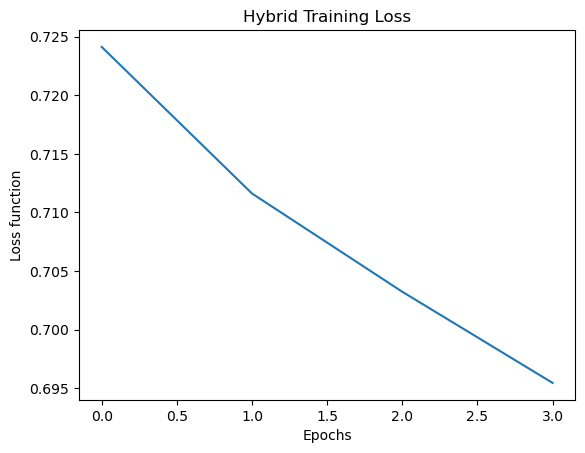

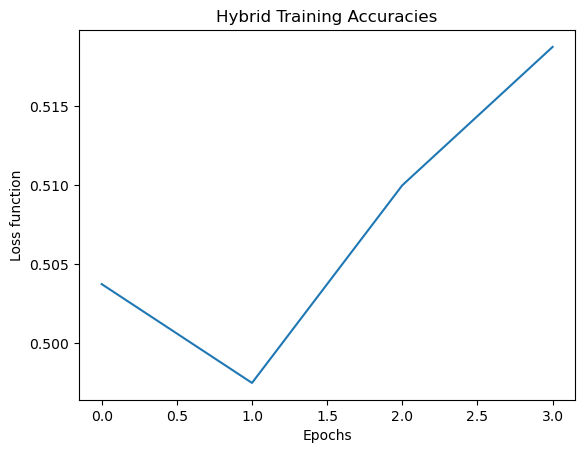

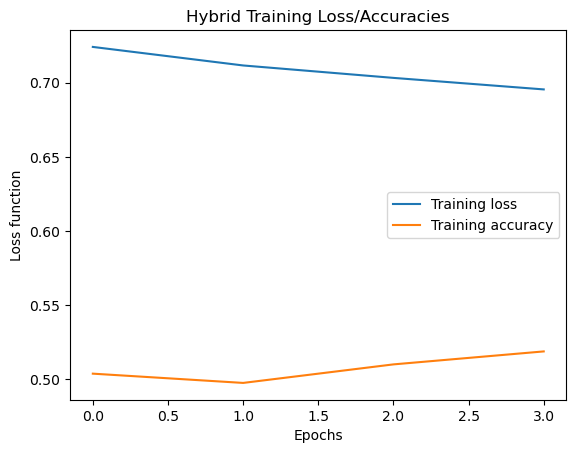

In [30]:
# plotting the training and validation loss
#GRAPHS

#------loss-validation/training-----
plt.plot(train_lossesq, label='Training loss')
plt.plot(val_lossesq, label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title("Hybrid NN Convergence")
#plt.yscale("log")
plt.savefig(model_folder+model_name+"LVThybrid.png")
plt.show()
#------loss-validation--------

plt.figure()
plt.title('Hybrid Validation Loss')
plt.plot(val_lossesq, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
#plt.savefig(ModelFolder+hybridModelName+"LVhybrid.png")
plt.show()
#------loss-training--------

plt.figure()
plt.title('Hybrid Training Loss')
plt.plot(train_lossesq, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
#Splt.savefig(ModelFolder+hybridModelName+"LThybrid.png")
plt.show()
#------accuracies-training--------
plt.figure()
plt.plot(accuracyTrainLossesq, label='Accuracy training')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Hybrid Training Accuracies')
plt.savefig(model_folder+model_name+"AThybrid.png")
plt.show()
#-----total-----
plt.figure()
plt.title('Hybrid Training Loss/Accuracies')
plt.plot(train_lossesq, label='Training loss')
plt.plot(accuracyTrainLossesq, label='Training accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.savefig(model_folder+model_name+"ALTVhybrid.png")
plt.show()

In [31]:
scores_train = torch.sigmoid(quantum_model(train_set_torch))[:,0]
scores_val = torch.sigmoid(quantum_model(val_set_torch))[:,0]

predictions_train = scores_train > 0.5
predictions_val = scores_val > 0.5
accuracy_train = (predictions_train == train_lb_torch).sum()/ train_lb_torch.shape[0]
accuracy_val = (predictions_val == val_lb_torch).sum()/ val_lb_torch.shape[0]

print("accuracy on training set: ", accuracy_train.numpy())
print("accuracy on validation set: ", accuracy_val.numpy())


accuracy on training set:  0.51875
accuracy on validation set:  0.545


In [32]:
# Saving data
with open(model_folder + model_name + ".txt", 'w') as fp:
    # Writing training losses
    fp.write("train_losses hybrid:\n\n")
    fp.writelines("%s\n" % item for item in train_lossesq)
    print('Train losses saved')

    # Writing validation losses
    fp.write("\nval_losses hybrid:\n\n")
    fp.writelines("%s\n" % item for item in val_lossesq)
    print('Val losses saved')

    # Writing accuracies
    fp.write("\naccuracies hybrid:\n\n")
    fp.writelines("%s\n" % item for item in accuracyTrainLossesq)
    print('Accuracies saved')

    # Writing accuracy on training
    fp.write("\naccuracy on training HYBRID:")
    fp.write(str(accuracy_train.numpy()))
    print('Accuracy on training saved')

    # Writing accuracy on validation
    fp.write("\naccuracy on validation HYBRID:")
    fp.write(str(accuracy_val.numpy()))
    print('Accuracy on validation saved')

# Saving the hybrid model
torch.save(quantum_model, model_folder + model_name + "Hybrid.pt")
print('Hybrid model saved')


Train losses saved
Val losses saved
Accuracies saved
Accuracy on training saved
Accuracy on validation saved
Hybrid model saved
